In [23]:
!pip install langdetect
from langdetect import detect
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import pandas as pd
import numpy as np



def detectar_idioma(texto):
    try:
        return detect(texto)
    except:
        return "desconocido"

def filtrar_idioma(df):

    df["idioma_detectado"] = df["review_es"].apply(detectar_idioma)

    return df[df["idioma_detectado"] == "es"]

def normalizar_texto(df, columna):
    reemplazos = {"á": "a", "é": "e", "í": "i", "ó": "o", "ú": "u"}
    df[columna] = df[columna].str.lower()
    for clave, valor in reemplazos.items():
        df[columna] = df[columna].str.replace(clave, valor)
    return df[columna]

def reemplazar_no(df):
    def reemplazo(texto):
        if isinstance(texto, str):
            return texto.replace(" película ", "")
        return texto

    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].apply(reemplazo)

    return df

def imprimir_resultados(y, y_pred):

    labels = [0, 1]

    f1 = f1_score(y, y_pred, pos_label=0, labels=labels)
    precision = precision_score(y, y_pred, pos_label=0, labels=labels)
    recall = recall_score(y, y_pred, pos_label=0, labels=labels)
    accuracy = accuracy_score(y, y_pred)

    cm = confusion_matrix(y, y_pred)

    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

    print(f"F1: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")

def guardar_resultado_en_csv(prediccion, df_test, ruta):

    prediccion = np.where(prediccion == 0, "negativo", "positivo")

    df_predicciones = pd.DataFrame({"ID": df_test["ID"], "prediccion": prediccion})

    df_predicciones.to_csv(ruta, header=["ID", "sentimiento"], index=False)

Defaulting to user installation because normal site-packages is not writeable


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [25]:
RUTA_TRAIN = "../train_limpio.csv"
RUTA_TEST = "../test.csv"

In [26]:
df_train = pd.read_csv(RUTA_TRAIN)
df_test = pd.read_csv(RUTA_TEST)

KeyboardInterrupt: 

In [ ]:
df_train["sentimiento"] = df_train["sentimiento"].map({"positivo": 1, "negativo": 0})

In [ ]:
RUTA_GUARDADO = "RED.csv"

In [ ]:
df_train.head(5)

,Unnamed: 0,ID,review_es,sentimiento,idioma_detectado
0,0,0,Uno de los otros críticos ha mencionado que de...,1,es
1,1,1,Una pequeña pequeña producción.La técnica de f...,1,es
2,2,2,Pensé que esta era una manera maravillosa de p...,1,es
3,3,3,"Básicamente, hay una familia donde un niño peq...",0,es
4,4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",1,es


In [ ]:
total_reviews = df_train["review_es"].astype(str)
total_labels = df_train["sentimiento"].values

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Entrenamiento")
    plt.plot(history.history["val_accuracy"], label="Validación")
    plt.title("Precisión del Modelo")
    plt.xlabel("Épocas")
    plt.ylabel("Precisión")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Entrenamiento")
    plt.plot(history.history["val_loss"], label="Validación")
    plt.title("Pérdida del Modelo")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.legend()

    plt.show()

In [ ]:
Y_data = df_train.sentimiento

In [ ]:
max_words = 5000
max_len = 100

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer_obj = Tokenizer(num_words = max_words)
tokenizer_obj.fit_on_texts(total_reviews)

In [ ]:
X_data_tokens = tokenizer_obj.texts_to_sequences(total_reviews)

In [ ]:
X_data_count = tokenizer_obj.sequences_to_matrix(X_data_tokens, mode = "count")

In [ ]:
X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(X_data_count, Y_data, test_size = 0.3, random_state = 123)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorboard.plugins.hparams import api as hp
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
# Definir early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

checkpoint = ModelCheckpoint("modeloRed.h5", monitor="val_accuracy", save_best_only=True, verbose=1)

# Ejemplo de ReduceLROnPlateau para ajustar la tasa de aprendizaje
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=0.0001)

# callbacks = [early_stopping, checkpoint, reduce_lr]
callbacks = [early_stopping, checkpoint]
# callbacks = [early_stopping]


ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=modeloRed.h5

In [ ]:
model_count = Sequential()
model_count.add(Dense(650, activation="relu", kernel_regularizer=regularizers.l2(0.01), input_shape=(5000,)))
model_count.add(Dropout(0.1))  # Ejemplo de cómo usar Dropout en lugar de Dense
model_count.add(Dense(250, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
model_count.add(Dropout(0.2))  # Ejemplo de cómo usar Dropout en lugar de Dense
model_count.add(Dense(35, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
model_count.add(Dense(1, activation="sigmoid"))

model_count.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [ ]:
history_count = model_count.fit(X_train_count, y_train_count, batch_size = 256, epochs = 100, validation_split=0.3,callbacks=callbacks)

Epoch 1/100
93/93 [==============================] - ETA: 0s - loss: 3.3161 - accuracy: 0.7959
Epoch 1: val_accuracy improved from -inf to 0.84840, saving model to best_model.h5
93/93 [==============================] - 20s 202ms/step - loss: 3.3161 - accuracy: 0.7959 - val_loss: 0.9117 - val_accuracy: 0.8484
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


93/93 [==============================] - ETA: 0s - loss: 0.7594 - accuracy: 0.8466
Epoch 2: val_accuracy improved from 0.84840 to 0.85008, saving model to best_model.h5
93/93 [==============================] - 14s 151ms/step - loss: 0.7594 - accuracy: 0.8466 - val_loss: 0.6376 - val_accuracy: 0.8501
Epoch 3/100
93/93 [==============================] - ETA: 0s - loss: 0.6028 - accuracy: 0.8543
Epoch 3: val_accuracy improved from 0.85008 to 0.86135, saving model to best_model.h5
93/93 [==============================] - 17s 182ms/step - loss: 0.6028 - accuracy: 0.8543 - val_loss: 0.5491 - val_accuracy: 0.8613
Epoch 4/100
93/93 [==============================] - ETA: 0s - loss: 0.5348 - accuracy: 0.8614
Epoch 4: val_accuracy did not improve from 0.86135
93/93 [==============================] - 14s 155ms/step - loss: 0.5348 - accuracy: 0.8614 - val_loss: 0.5245 - val_accuracy: 0.8560
Epoch 5/100
93/93 [==============================] - ETA: 0s - loss: 0.5009 - accuracy: 0.8669
Epoch 5: val_

In [ ]:
test_loss, test_acc = model_count.evaluate(X_test_count, y_test_count)
print()
print(test_loss, test_acc)

452/452 [==============================] - 8s 17ms/step - loss: 0.4452 - accuracy: 0.8718

0.4452272951602936 0.8718090653419495


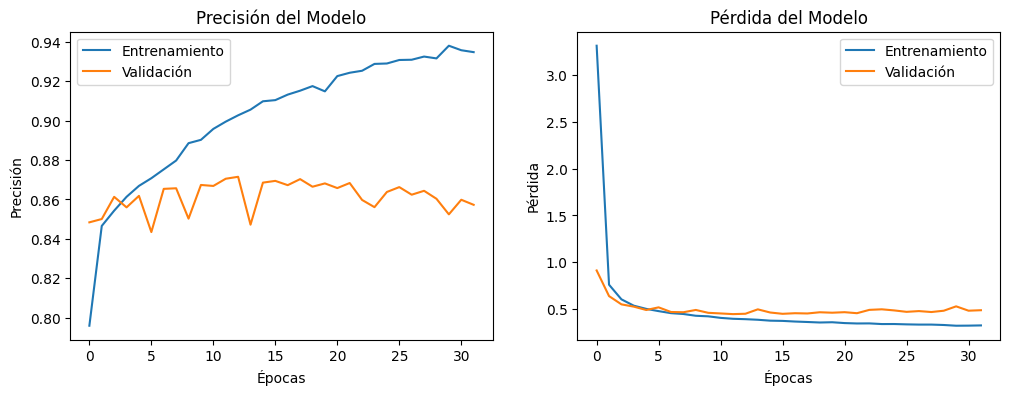

In [ ]:
plot_training_history(history_count)

In [ ]:
X_train_tokens = tokenizer_obj.texts_to_sequences(df_test["review_es"])
X_train_count = tokenizer_obj.sequences_to_matrix(X_train_tokens, mode = "count")
y_pred = model_count.predict(X_test_count)
y_pred = np.round(y_pred)

452/452 [==============================] - 5s 11ms/step


F1: 0.8739884393063585
Precision: 0.8613941018766756
Recall: 0.8869565217391304
Accuracy: 0.8718090626080941


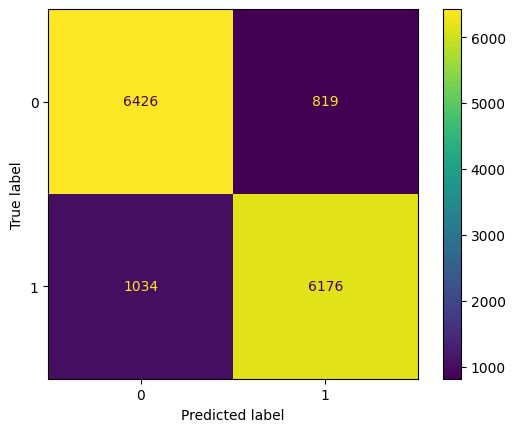

In [ ]:
imprimir_resultados(y_test_count, y_pred)

In [ ]:
X_test_tokens = tokenizer_obj.texts_to_sequences(df_test["review_es"])
X_test_count = tokenizer_obj.sequences_to_matrix(X_test_tokens, mode = "count")
y_pred = model_count.predict(X_test_count)
y_pred = np.round(y_pred)

269/269 [==============================] - 3s 9ms/step


In [ ]:
y_pred

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
y_pred = np.where(y_pred == 0, "negativo", "positivo")

In [ ]:
df_predicciones = pd.DataFrame({"ID": df_test["ID"], "prediccion": y_pred.flatten()})

df_predicciones.to_csv(RUTA_GUARDADO, header=["ID", "sentimiento"], index=False)